[Reference](https://colab.research.google.com/drive/1WZxs6zaXkLYkRIEPiAAMBoht7b_8kbCO)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython import display
display.set_matplotlib_formats("svg")

iris = pd.read_csv("https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv")
iris.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [2]:
X = torch.tensor(iris.drop("variety", axis=1).values, dtype=torch.float)
y = torch.tensor(
    [0 if vty == "Setosa" else 1 if vty == "Versicolor" else 2 for vty in iris["variety"]], 
    dtype=torch.long
)

print(X.shape, y.shape)

torch.Size([150, 4]) torch.Size([150])


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, shuffle=True, batch_size=12)
test_loader = DataLoader(test_data, batch_size=len(test_data.tensors[0]))

print("Training data batches:")
for X, y in train_loader:
    print(X.shape, y.shape)
    
print("\nTest data batches:")
for X, y in test_loader:
    print(X.shape, y.shape)

Training data batches:
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])

Test data batches:
torch.Size([30, 4]) torch.Size([30])


# Train Your First Neural Network with PyTorch


In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(in_features=4, out_features=16)
        self.hidden_1 = nn.Linear(in_features=16, out_features=16)
        self.output = nn.Linear(in_features=16, out_features=3)
        
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden_1(x))
        return self.output(x)
    
    
model = Net()
print(model)

Net(
  (input): Linear(in_features=4, out_features=16, bias=True)
  (hidden_1): Linear(in_features=16, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=3, bias=True)
)


In [5]:
num_epochs = 200
train_accuracies, test_accuracies = [], []

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

for epoch in range(num_epochs):
    # Train set
    for X, y in train_loader:
        preds = model(X)
        pred_labels = torch.argmax(preds, axis=1)
        loss = loss_function(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_accuracies.append(
        100 * torch.mean((pred_labels == y).float()).item()
    )
    
    # Test set
    X, y = next(iter(test_loader))
    pred_labels = torch.argmax(model(X), axis=1)
    test_accuracies.append(
        100 * torch.mean((pred_labels == y).float()).item()
    )

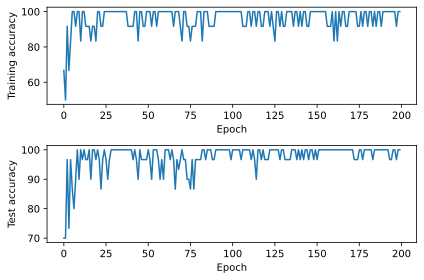

In [6]:
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(nrows=2, ncols=1)

ax = fig.add_subplot(gs[0, 0])
ax.plot(train_accuracies)
ax.set_xlabel("Epoch")
ax.set_ylabel("Training accuracy")

ax = fig.add_subplot(gs[1, 0])
ax.plot(test_accuracies)
ax.set_xlabel("Epoch")
ax.set_ylabel("Test accuracy")

fig.align_labels()
plt.show()

# How to Optimize Your Neural Network Models in PyTorch


In [7]:
def train_model(train_loader, test_loader, model, lr=0.01, num_epochs=200):
    train_accuracies, test_accuracies, losses = [], [], []
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        for X, y in train_loader:
            preds = model(X)
            pred_labels = torch.argmax(preds, axis=1)
            loss = loss_function(preds, y)
            losses.append(loss.detach().numpy())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        train_accuracies.append(
            100 * torch.mean((pred_labels == y).float()).item()
        )
        
        X, y = next(iter(test_loader))
        pred_labels = torch.argmax(model(X), axis=1)
        test_accuracies.append(
            100 * torch.mean((pred_labels == y).float()).item()
        )
 
    return train_accuracies[-1], test_accuracies[-1]


train_model(train_loader, test_loader, Net())

(100.0, 96.66666388511658)

In [8]:
class Net2(nn.Module):
    def __init__(self, n_units, n_layers):
        super().__init__()
        self.n_layers = n_layers
        
        self.layers = nn.ModuleDict()
        self.layers["input"] = nn.Linear(in_features=4, out_features=n_units)
        
        for i in range(self.n_layers):
            self.layers[f"hidden_{i}"] = nn.Linear(in_features=n_units, out_features=n_units)
            
        self.layers["output"] = nn.Linear(in_features=n_units, out_features=3)
        
    def forward(self, x):
        x = self.layers["input"](x)
        
        for i in range(self.n_layers):
            x = F.relu(self.layers[f"hidden_{i}"](x))
            
        return self.layers["output"](x)

In [9]:
n_layers = np.arange(1, 5)
n_units = np.arange(8, 65, 8)
train_accuracies, test_accuracies = [], []

for i in range(len(n_units)):
    for j in range(len(n_layers)):
        model = Net2(n_units=n_units[i], n_layers=n_layers[j])
        train_acc, test_acc = train_model(train_loader, test_loader, model)
        train_accuracies.append({
            "n_layers": n_layers[j],
            "n_units": n_units[i],
            "accuracy": train_acc
        })
        test_accuracies.append({
            "n_layers": n_layers[j],
            "n_units": n_units[i],
            "accuracy": test_acc
        })
        
        
train_accuracies = pd.DataFrame(train_accuracies).sort_values(by=["n_layers", "n_units"]).reset_index(drop=True)
test_accuracies = pd.DataFrame(test_accuracies).sort_values(by=["n_layers", "n_units"]).reset_index(drop=True)
test_accuracies.head()

,n_layers,n_units,accuracy
0,1,8,96.666664
1,1,16,96.666664
2,1,24,96.666664
3,1,32,96.666664
4,1,40,100.000000


In [10]:
test_accuracies[test_accuracies["accuracy"] == test_accuracies["accuracy"].max()]

,n_layers,n_units,accuracy
4,1,40,100.0
5,1,48,100.0
6,1,56,100.0
8,2,8,100.0
15,2,64,100.0
17,3,16,100.0
18,3,24,100.0
21,3,48,100.0
30,4,56,100.0
